# Indiana Pines

1. Import dependencies

In [ ]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from lightning import Trainer
from torch import nn
from torch import optim

from src.util.image import (
    scale_image,
    reduce_depth_with_autoencoder,
    reduce_depth_with_patched_autoencoder,
    reduce_depth_with_pca,
)
from src.util.patches import extract_patches
from src.util.torch_device import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.visualization.plot import plot_segmentation_comparison, plot_epoch_generic
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.model.autoencoder import SpatialAutoEncoder, SymmetricPointWiseAutoEncoder
from src.trainer.autoencoder_trainer import AutoEncoderTrainer
from src.trainer.co_trainer import BiCoTrainer
from src.model.ensemble import Ensemble
from src.trainer.base_trainer import AdamOptimizedModule
from src.trainer.classification_trainer import ClassificationTrainer
from src.util.hsi import train_test_band_patch_split
from src.model.hsi_vit import HsiVisionTransformer

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 64
patch_size = 9
fraction_of_examples = 0.1
examples_per_class = 20

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [3]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [4]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

_, x = scale_image(image)

In [5]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

4. Reduce dimensions

In [6]:
reduced_dim_size = 200

In [7]:
# _, x = reduce_depth_with_pca(x, n_components=reduced_dim_size)

In [8]:
# auto_encoder_epochs = 100

# autoencoder = SymmetricPointWiseAutoEncoder([image_c, reduced_dim_size]).to(device)

# criterion = nn.MSELoss().to(device)
# optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
# trainer = AutoEncoderTrainer(
#     criterion,
#     auto_encoder_epochs,
#     optimizer,
# )

# x = reduce_depth_with_autoencoder(x, autoencoder, trainer, device)

In [9]:
# auto_encoder_epochs = 100
# reduced_dim_size = 50

# autoencoder = SpatialAutoEncoder(
#     input_channels=image_c, embedding_size=reduced_dim_size
# ).to(device)

# trainer = AutoEncoderTrainer(
#     nn.MSELoss(),
#     auto_encoder_epochs,
#     optim.Adam(autoencoder.parameters(), lr=1e-3),
# )

# x = reduce_depth_with_patched_autoencoder(x, patch_size, autoencoder, [trainer], device)

5. Prepare dataset

In [10]:
x, y = extract_patches(x, labels, patch_size=patch_size)

examples_per_class_arr = np.repeat(examples_per_class, num_classes)

x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
    x, y, examples_per_class_arr
)

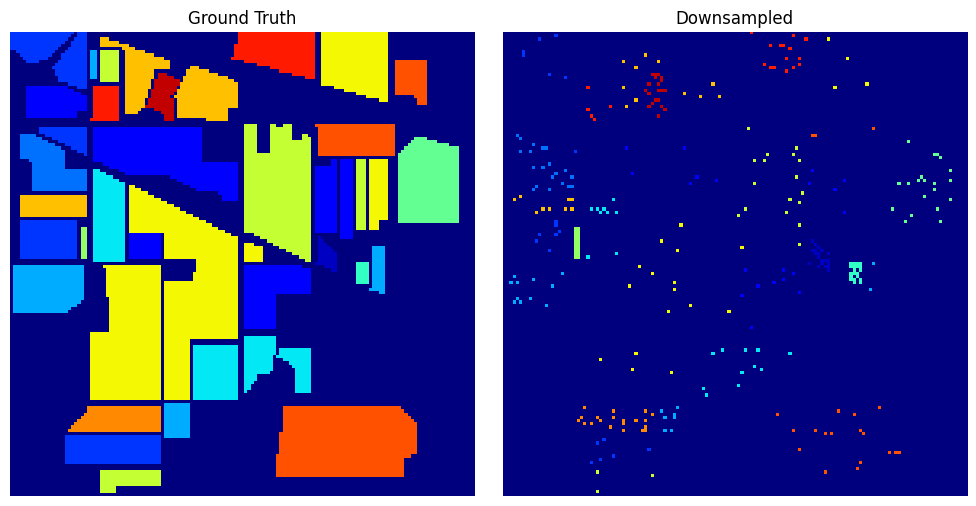

In [11]:
plot_segmentation_comparison(labels, y_masked.reshape(labels.shape), title2="Downsampled")

In [12]:
x_train.shape

(340, 9, 9, 200)

In [13]:
x_all = torch.tensor(x, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
y_all = torch.tensor(y, dtype=torch.long, device=device)
x_train = torch.tensor(x_train, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
x_test = torch.tensor(x_test, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [14]:
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test, y_test)
full_dataset = data.TensorDataset(x_all, y_all)

In [15]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)

In [16]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

In [17]:
hidden_dim = 64
num_layers = 5
num_heads = 4
mlp_dim = 8
dropout = 0.1
learning_rate = 5e-4
num_epochs = 15
weight_decay = 5e-3
scheduler_step_size = num_epochs // 10
scheduler_gamma = 0.9

In [ ]:
model = AdamOptimizedModule(
    HsiVisionTransformer(
        num_classes=num_classes,
        input_shape=(image_c, patch_size, patch_size),
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
    ),
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
).to(device)

loss = nn.CrossEntropyLoss()

trainer = ClassificationTrainer(
    num_epochs, num_classes, loss, device, validate_every_n_steps=10
)

In [19]:
feedback = trainer.fit(model, train_loader, test_loader)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


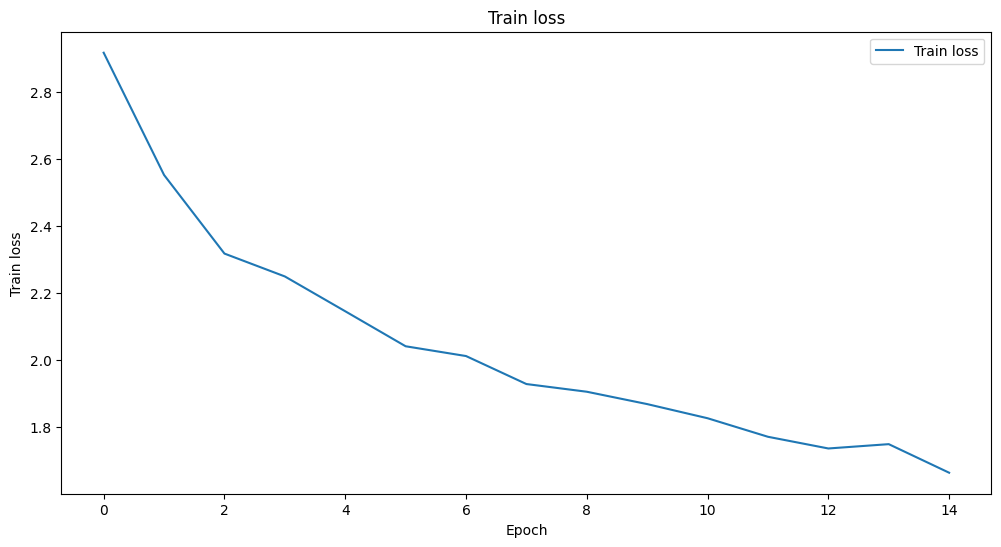

In [20]:
plot_epoch_generic(
    [it.train["train_loss"] for it in feedback.history],
    desc="Train loss",
)

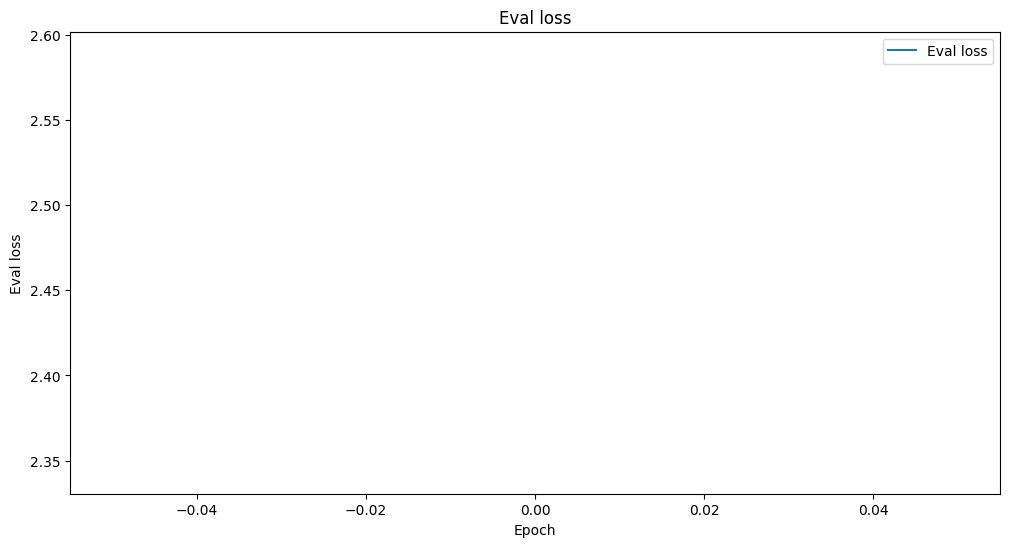

In [21]:
plot_epoch_generic(
    [it.eval["eval_loss"] for it in feedback.history if "eval_loss" in it.eval],
    desc="Eval loss",
)

5. Display prediction

In [22]:
trainer.validate(model, test_loader)

{'eval_f1': 0.15217913687229156,
 'eval_accuracy_overall': 0.41019678115844727,
 'eval_accuracy_avg': 0.19613246619701385,
 'eval_kappa': 0.15417546033859253,
 'eval_loss': 2.4055681228637695}

In [23]:
_, y_pred = trainer.predict(model, predict_loader)

In [24]:
y_pred = torch.cat(y_pred, dim=0)

In [25]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

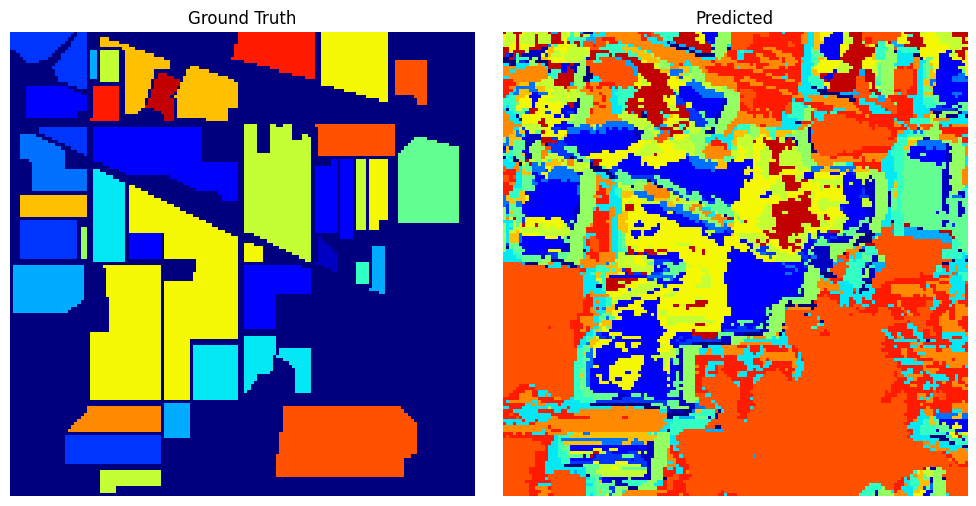

In [26]:
plot_segmentation_comparison(labels, y_pred.cpu().numpy())

6. Train semi-supervised model

In [27]:
model_1 = AdamOptimizedModule(
    HsiVisionTransformer(
        num_classes=num_classes,
        input_shape=(image_c, patch_size, patch_size),
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
    ),
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
).to(device)

model_2 = AdamOptimizedModule(
    HsiVisionTransformer(
        num_classes=num_classes,
        input_shape=(image_c, patch_size, patch_size),
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
    ),
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
).to(device)

loss = nn.CrossEntropyLoss()

co_trainer = BiCoTrainer(
    batch_size=batch_size,
    confidence_threshold=0.9,
    generator=generator,
    trainer=ClassificationTrainer(
        num_epochs=num_epochs,
        num_classes=num_classes,
        criterion=loss,
        device=device,
        record_history=False,
    ),
)

In [28]:
feedback = co_trainer.fit(
    models=(model_1, model_2),
    labeled=train_dataset,
    unlabeled=test_dataset,
    eval_dl=test_loader,
)

0it [00:00, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [29]:
feedback.history[-1].eval

{'eval_f1': 0.12771886587142944,
 'eval_accuracy_overall': 0.23611924052238464,
 'eval_accuracy_avg': 0.12893401086330414,
 'eval_kappa': 0.08604145050048828,
 'eval_loss': 2.8229219913482666}

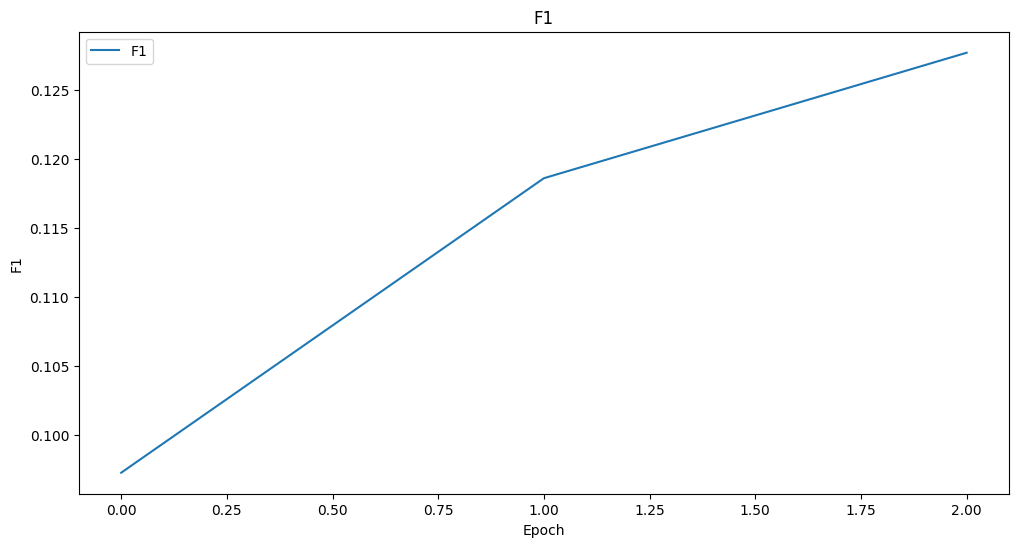

In [30]:
plot_epoch_generic(
    [it.eval["eval_f1"] for it in feedback.history], desc="F1"
)

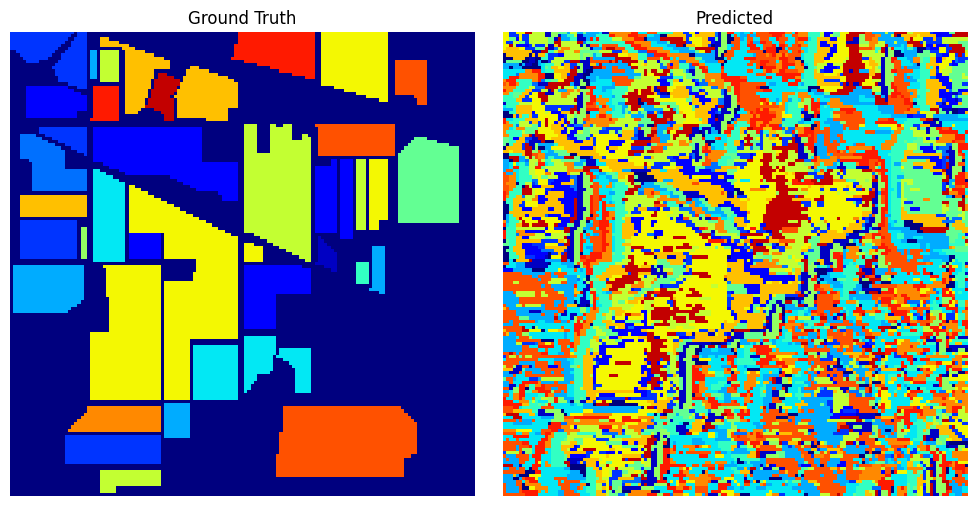

In [31]:
co_trained = Ensemble([model_1, model_2]).to(device)

_, y_pred = trainer.predict(co_trained, predict_loader)
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

plot_segmentation_comparison(labels, y_pred.cpu().numpy())